## Load libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
# plt.rcParams['figure.figsize'] = (25, 6)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6) 

## Process datasets

### Merge the dataset 20171129
1. Merge the dataset to point_spread.csv and matches.csv
2. Unify the team name
  * JAX -> JAC (NFL use JAX, but just for unification)
  * Buffalo -> BUF
  * LAC -> SD
  * LA -> STL

### Read feature datasets 
from 2009 to 2017

In [2]:
play_cols = ['GameID','Drive','qtr','down','yrdline100','posteam','DefensiveTeam','TimeSecs','sp','ScoreDiff',
            'HomeTeam','AwayTeam']

In [3]:
spread_cols = ['eid','season','week','Home','Away','HomeScore','AwayScore','Day','Time','Favorite','Underdog','Spread','CoverOrNot']

In [4]:
data_files = glob.glob('data/new_data/pbp_20*.csv') # from 2009 to 2017

pbp_data = pd.DataFrame()
for f in data_files:
    d = pd.read_csv(f, usecols=play_cols)
    pbp_data = pd.concat([pbp_data, d])
pbp_data.shape

(388476, 12)

### Merge point spread data

In [5]:
spread_data = pd.read_csv('data/point_spread.csv')

In [6]:
data = pd.merge(pbp_data, spread_data, on='GameID', how='left')

### Deal with missing data

In [7]:
data = data.dropna(axis=0, how='any')

In [8]:
data.shape

(319576, 24)

In [9]:
data = data[data['TimeSecs'] >= 0]

#### Columns to include in the formation of buckets [Down, TimeSecs, YdsToGo and Score Diff]

In [10]:
data['FavScoreDiff'] = data[['posteam','ScoreDiff','Favorite']].apply(
    lambda x: x['ScoreDiff'] if x['posteam']==x['Favorite'] else (-x['ScoreDiff']),axis=1)

In [11]:
data['favTeamOnBall'] = data[['Favorite','posteam']].apply(lambda x: 1 if x['Favorite']==x['posteam'] else -1, axis=1)

## Creating the buckets

In [12]:
data['DownClass'] = pd.cut(data['down'],4, labels=False)

In [13]:
data['TimeSecsClass'] = pd.cut(data['TimeSecs'],60, labels=False)

In [14]:
data['yrdline100Class'] = pd.cut(data['yrdline100'],10, labels=False)

In [15]:
data['FavScoreDiffClass'] = pd.cut(data['FavScoreDiff'],10, labels=False)

In [16]:
class_names = ['FavScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass']

In [17]:
# Count the total plays in each bucket irrespective of bet_cleared or not
countNoZero = data.groupby(class_names).size().reset_index(name='counts')

Now temp contains the count of each existing class. From here, we've to add 0 for values of the classes that don't exist. The following code does that.

In [18]:
# Counting the values in each bucket
bucket_full = pd.pivot_table(countNoZero,
                           index=class_names,
                           values='counts',
                           fill_value = 0,
                           dropna=False,
                           aggfunc=np.sum)

new_table stores the count for each class.

In [19]:
bucket_full['counts'] = bucket_full['counts']+2

In [21]:
full_buc_count = list(bucket_full['counts'])

Now we will work to get the count for each bucket with only the matches for which the bet was cleared

In [22]:
class_names = ['CoverOrNot','FavScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass']

In [23]:
countNoZeroCover = data.groupby(class_names).size().reset_index(name='counts')

In [24]:
# Counting the plays in each bucket for which the bet was cleared
bucket_half = pd.pivot_table(countNoZeroCover,
                           index=class_names,
                           values='counts',
                           fill_value = 0,
                           dropna=False,
                           aggfunc=np.sum)

In [25]:
bucket_half['counts'] = bucket_half['counts']+1

In [26]:
half_buc_count = list(bucket_half['counts'].loc[bucket_half.index.get_level_values('CoverOrNot')==1])

In [27]:
# Final Probability vector for each bucket
prob_buc = [float(half_buc_count[i])/float(full_buc_count[i]) for i in range(len(full_buc_count))]

**prob_buc** stores the probability of bet clearing probability of each bucket

In [28]:
bucket_full['counts'] = prob_buc

In [29]:
bucket_full.head()

counts
FavScoreDiffClass yrdline100Class TimeSecsClass DownClass          
0                 0               0             0          0.500000
                                                1          0.500000
                                                2          0.333333
                                                3          0.500000
                                  1             0          0.333333

#### As clear from the above structure, bucket_full now contains the probability of each bucket.
We will now use these probabilities to assign each play a probability based on which bucket that play lies in

## Assigning each play a probability wrt it's bucket

In [30]:
bucket_full = bucket_full.reset_index()

In [31]:
data = pd.merge(data, bucket_full, on=['FavScoreDiffClass','yrdline100Class','TimeSecsClass','DownClass'], how='left')

In [32]:
data = data.rename(columns={"counts":"Prob"})

In [33]:
data.head()

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,...,Underdog,Spread,CoverOrNot,FavScoreDiff,favTeamOnBall,DownClass,TimeSecsClass,yrdline100Class,FavScoreDiffClass,Prob
0,2013090500,1,1,1.0,3600.0,80.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,0,59,8,4,0.465719
1,2013090500,1,1,2.0,3554.0,81.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,1,59,8,4,0.442890
2,2013090500,1,1,3.0,3518.0,78.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,2,58,7,4,0.520737
3,2013090500,1,1,4.0,3498.0,72.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,3,58,7,4,0.459350
4,2013090500,2,1,1.0,3490.0,77.0,DEN,BAL,0,0.0,...,BAL,-7.5,1.0,0.0,1,0,58,7,4,0.479508


### Plots

#### Fixing score difference, graph of time left vs Prob

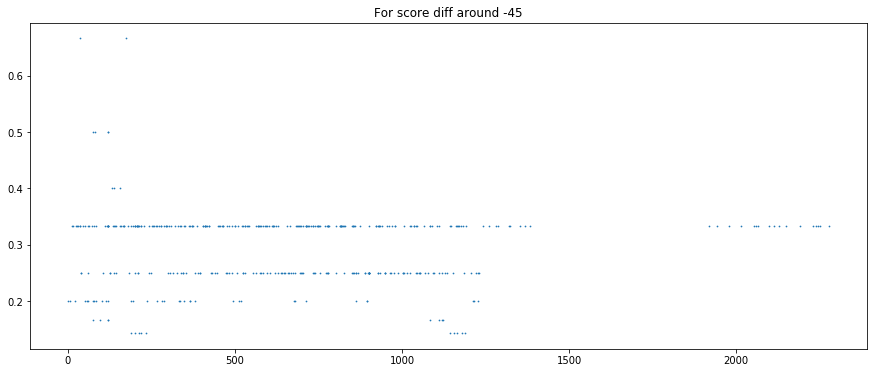

In [55]:
small_data = data[data['FavScoreDiffClass']==0]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.5)
plt.title('For score diff around -45')
plt.show()

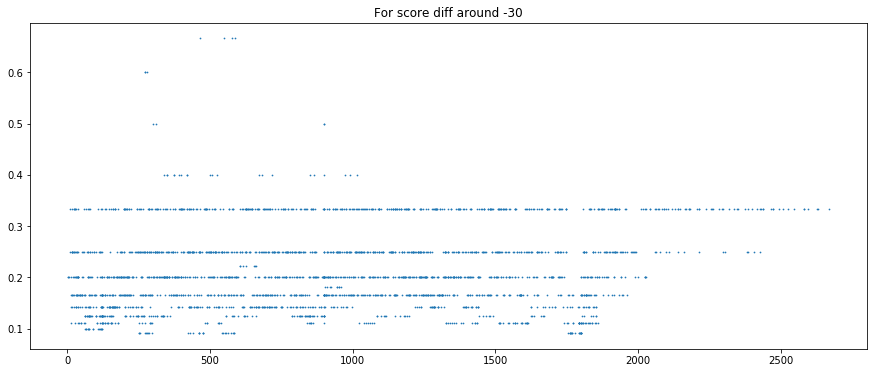

In [56]:
small_data = data[data['FavScoreDiffClass']==1]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.5)
plt.title('For score diff around -30')
plt.show()

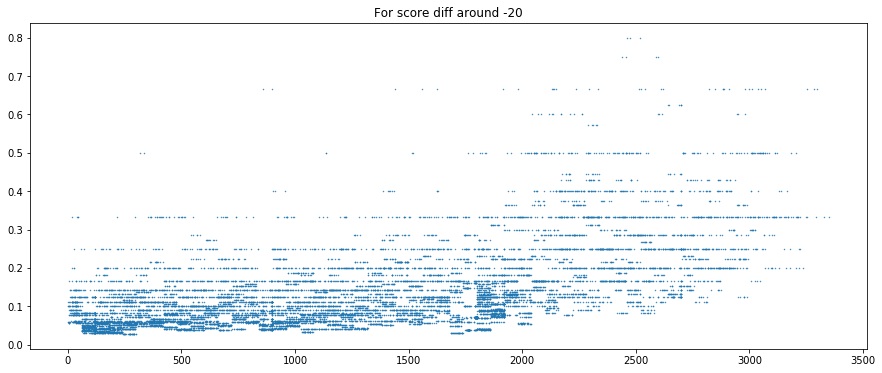

In [57]:
small_data = data[data['FavScoreDiffClass']==2]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around -20')
plt.show()

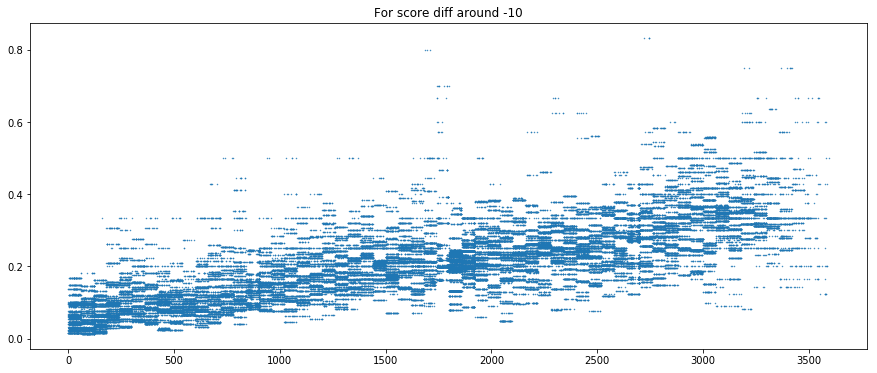

In [58]:
small_data = data[data['FavScoreDiffClass']==3]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around -10')
plt.show()

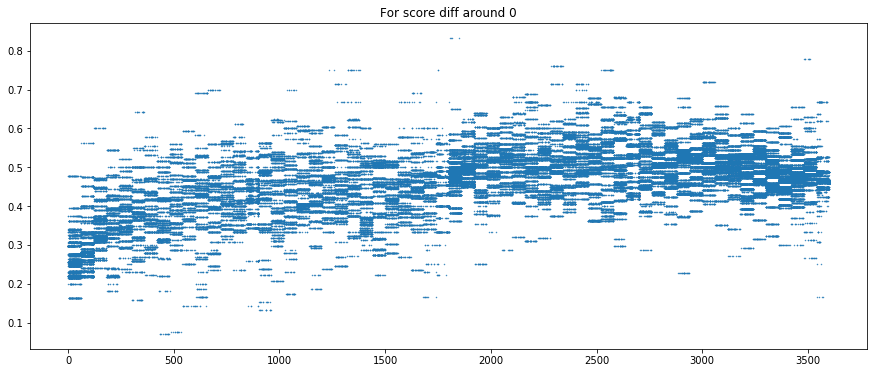

In [71]:
small_data = data[data['FavScoreDiffClass']==4]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 0')
plt.show()

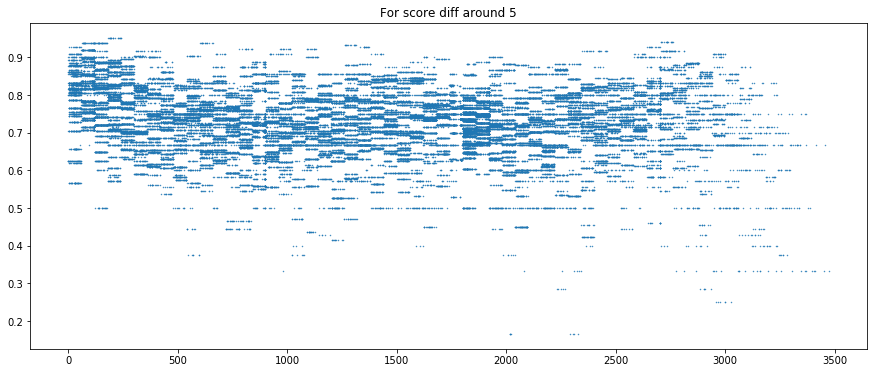

In [70]:
small_data = data[data['FavScoreDiffClass']==5]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 5')
plt.show()

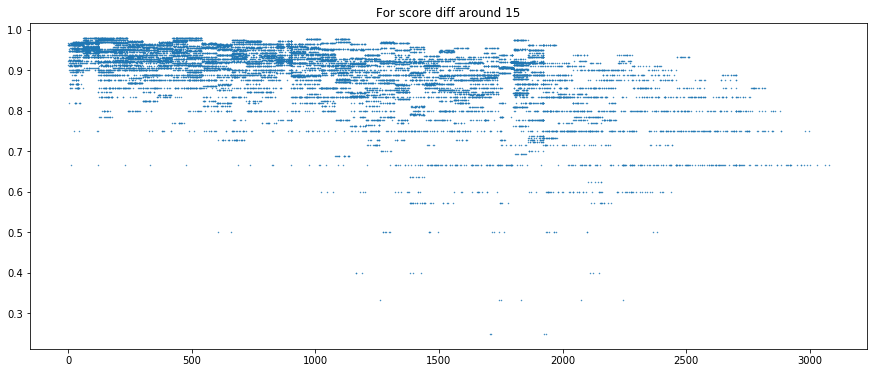

In [69]:
small_data = data[data['FavScoreDiffClass']==6]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 15')
plt.show()

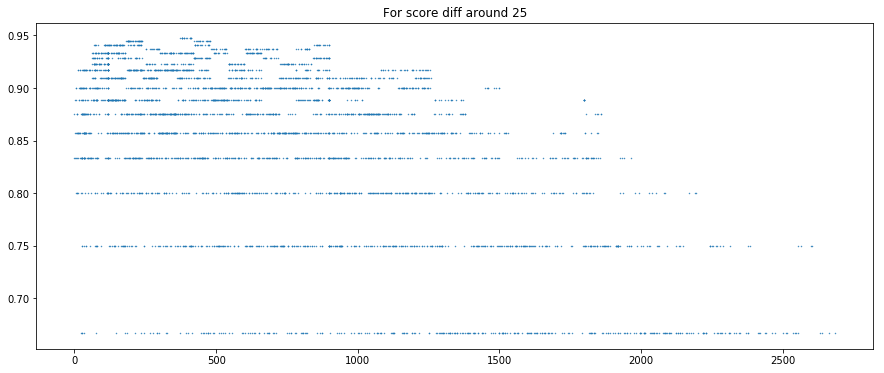

In [68]:
small_data = data[data['FavScoreDiffClass']==7]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 25')
plt.show()

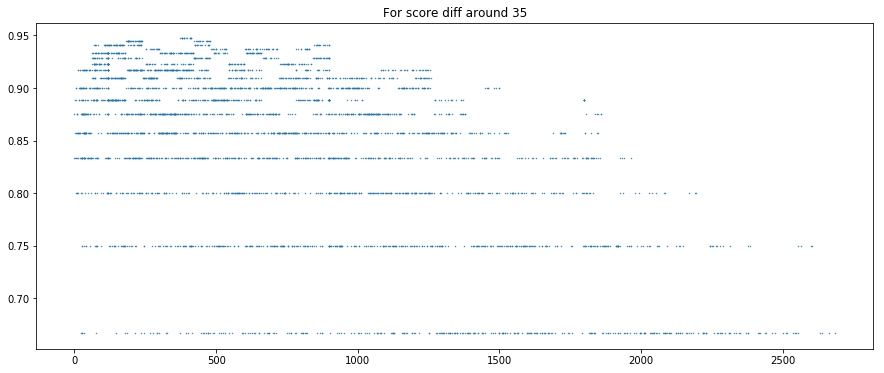

In [67]:
small_data = data[data['FavScoreDiffClass']==7]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 35')
plt.show()

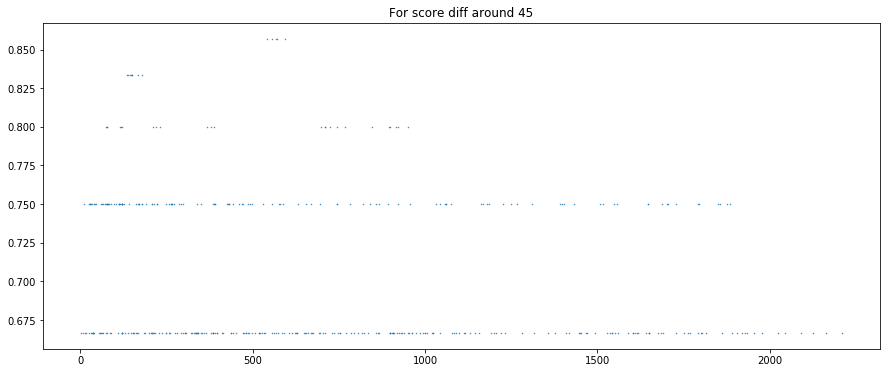

In [66]:
small_data = data[data['FavScoreDiffClass']==8]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 45')
plt.show()

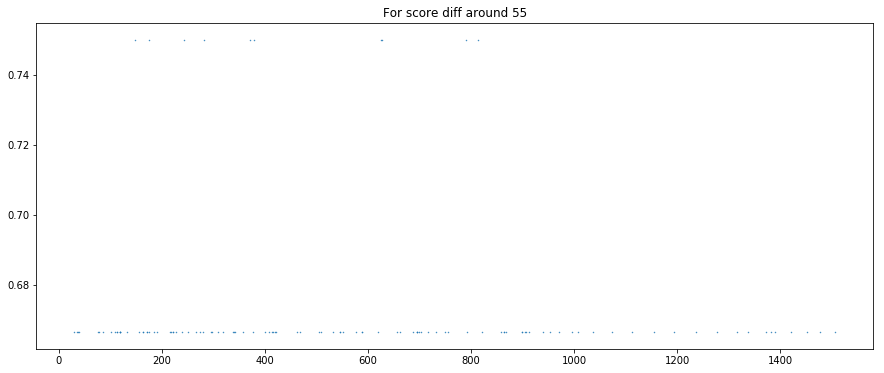

In [65]:
small_data = data[data['FavScoreDiffClass']==9]
plt.scatter(small_data['TimeSecs'],small_data['Prob'],s=0.2)
plt.title('For score diff around 55')
plt.show()

In [73]:
data.head()

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,...,Underdog,Spread,CoverOrNot,FavScoreDiff,favTeamOnBall,DownClass,TimeSecsClass,yrdline100Class,FavScoreDiffClass,Prob
0,2013090500,1,1,1.0,3600.0,80.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,0,59,8,4,0.465719
1,2013090500,1,1,2.0,3554.0,81.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,1,59,8,4,0.442890
2,2013090500,1,1,3.0,3518.0,78.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,2,58,7,4,0.520737
3,2013090500,1,1,4.0,3498.0,72.0,BAL,DEN,0,0.0,...,BAL,-7.5,1.0,-0.0,-1,3,58,7,4,0.459350
4,2013090500,2,1,1.0,3490.0,77.0,DEN,BAL,0,0.0,...,BAL,-7.5,1.0,0.0,1,0,58,7,4,0.479508


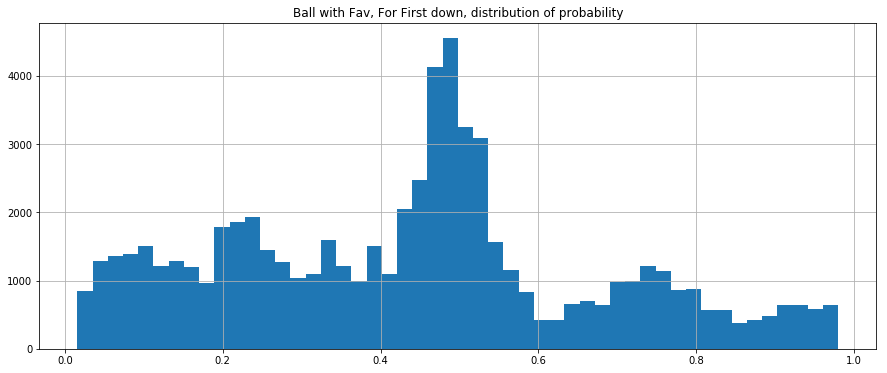

In [87]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==0)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For First down, distribution of probability')
plt.show()

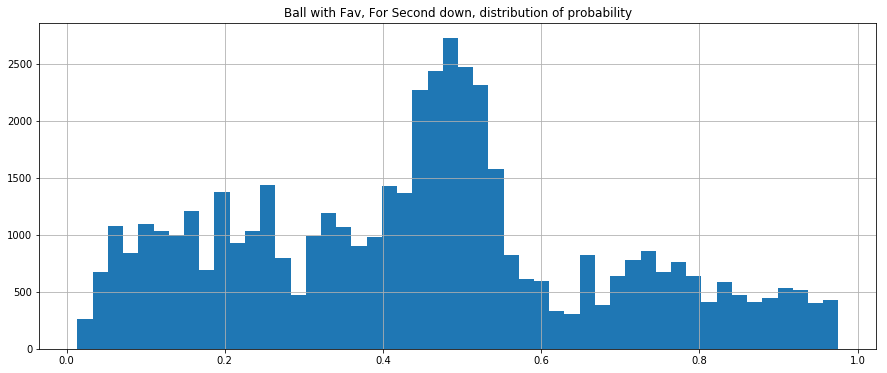

In [88]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==1)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For Second down, distribution of probability')
plt.show()

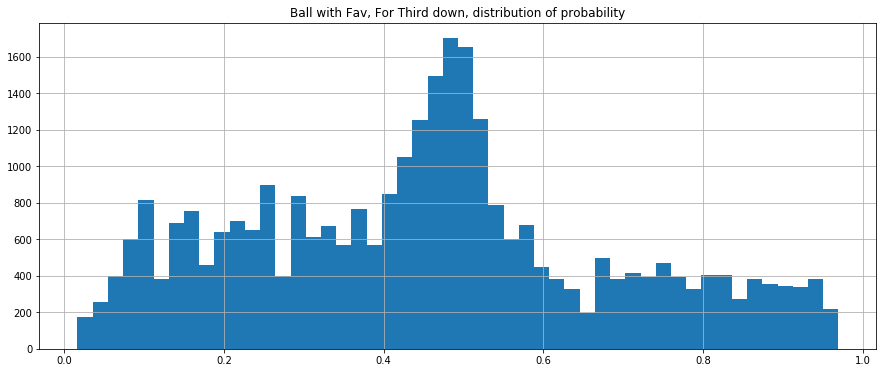

In [89]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==2)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For Third down, distribution of probability')
plt.show()

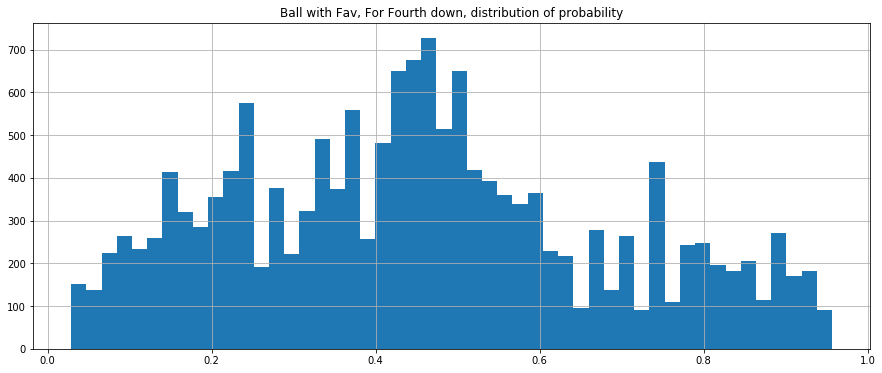

In [90]:
small_data = data[(data['favTeamOnBall']==1) & (data['DownClass']==3)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Fav, For Fourth down, distribution of probability')
plt.show()

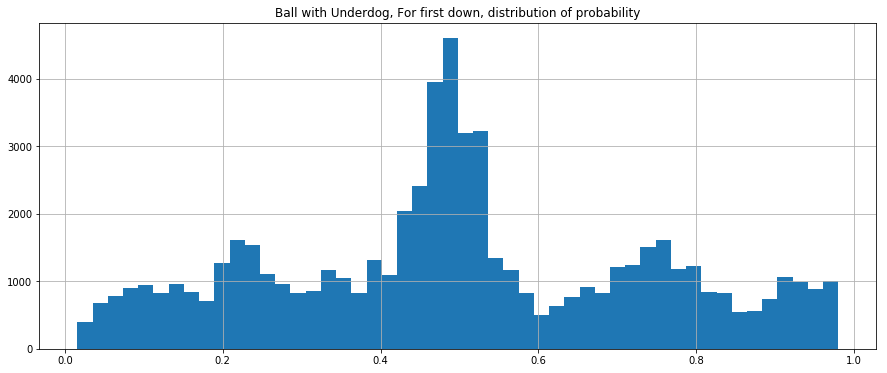

In [91]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==0)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For first down, distribution of probability')
plt.show()

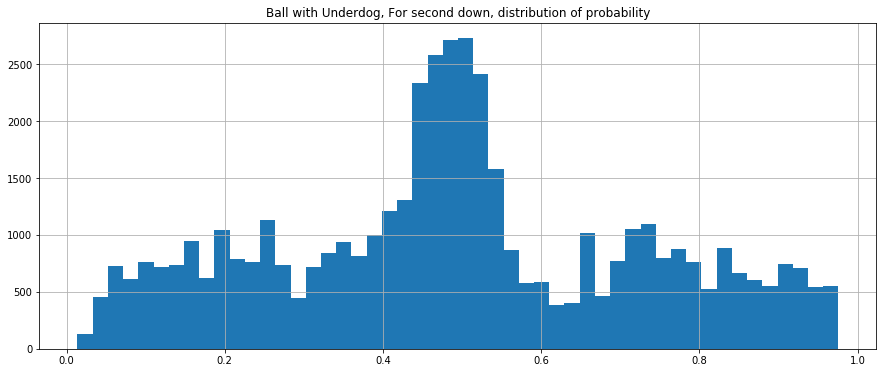

In [92]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==1)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For second down, distribution of probability')
plt.show()

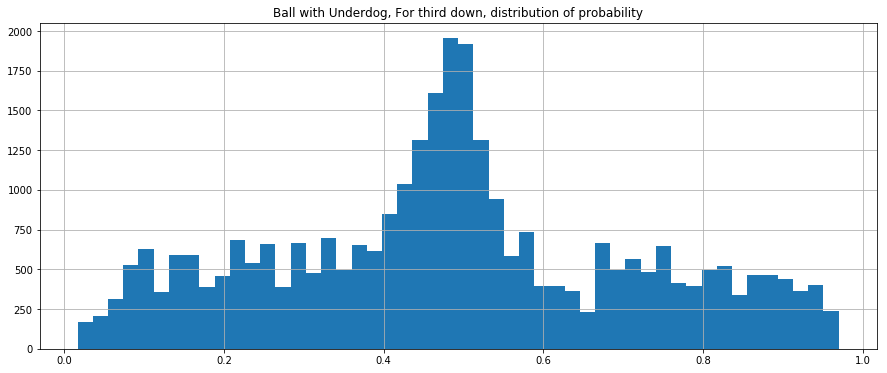

In [93]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==2)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For third down, distribution of probability')
plt.show()

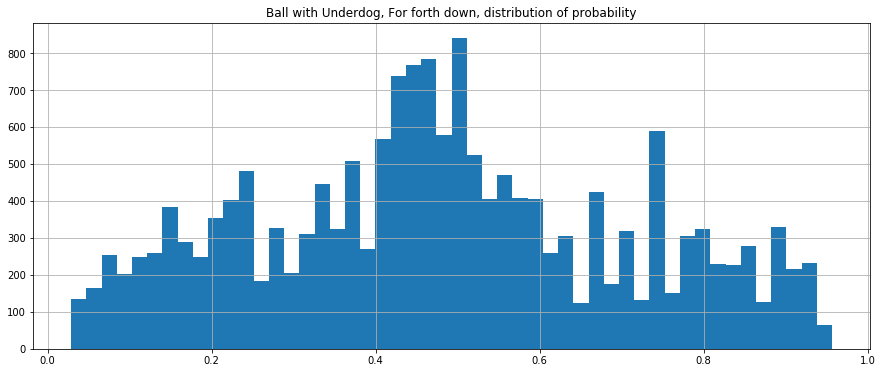

In [94]:
small_data = data[(data['favTeamOnBall']==-1) & (data['DownClass']==3)]
small_data['Prob'].hist(bins=50)
plt.title('Ball with Underdog, For forth down, distribution of probability')
plt.show()

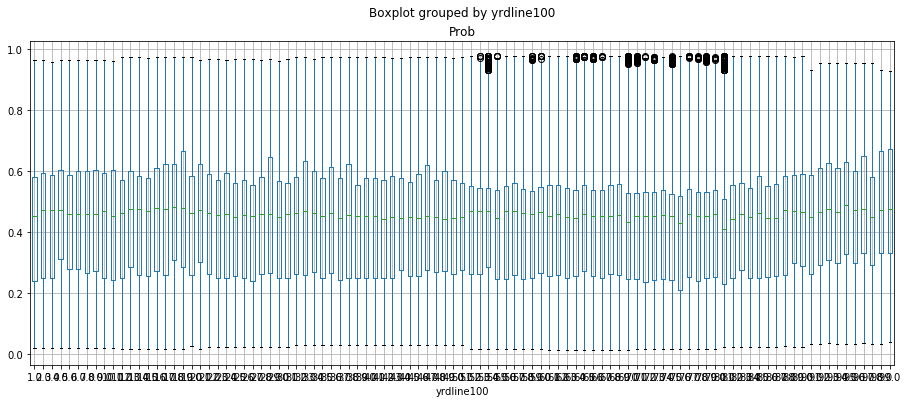

In [100]:
small_data = data[data['favTeamOnBall']==1]
small_data[['Prob','yrdline100']].boxplot(column='Prob',by='yrdline100')
plt.show()